Credit to Lex and his references
https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets

In [1]:
%matplotlib inline  
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# style.use('fivethirtyeight')
# sns.set(style='whitegrid',color_codes=True)

from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from sklearn.utils import shuffle

print(os.listdir("../input"))

['resized-2015-2019-blindness-detection-images', 'resnet50', 'aptos2019-blindness-detection', 'resnet34']


In [2]:
# def seed_everything(seed):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

# SEED = 88
# seed_everything(SEED)

In [3]:
# copy pretrained weights for resnet34 to the folder fastai will search by default
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp '../input/resnet50/resnet50.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'

In [4]:
df_train = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/trainLabels15.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

# x_train = df_train['id_code']
# y_train = df_train['diagnosis']

In [5]:
df_train = df_train.rename(columns={"image": "id_code", "level": "diagnosis"})
df_train.head()


,id_code,diagnosis
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


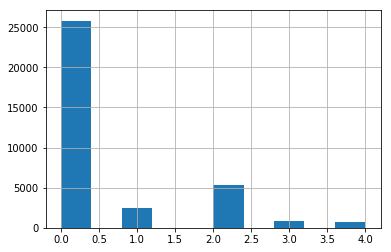

In [6]:
df_train.diagnosis.hist()

In [7]:
import torch
import torch.utils.data
import torchvision

In [8]:
print(os.listdir("../input/aptos2019-blindness-detection/")) 

['train.csv', 'sample_submission.csv', 'test_images', 'train_images', 'test.csv']


In [9]:
def get_label(diagnosis):
    return ','.join([str(i) for i in range(diagnosis + 1)])

In [10]:
df_train['label'] = df_train.diagnosis.apply(get_label)

In [11]:
df_train.head(10)

,id_code,diagnosis,label
0,10_left,0,0
1,10_right,0,0
2,13_left,0,0
3,13_right,0,0
4,15_left,1,"0,1"
5,15_right,2,"0,1,2"
6,16_left,4,"0,1,2,3,4"
7,16_right,4,"0,1,2,3,4"
8,17_left,0,0
9,17_right,1,"0,1"


In [12]:
tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0.2, 0.8), 'col_pct': (0.2, 0.8), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [13]:
# create image data bunch
data = ImageDataBunch.from_df('./', 
                              df=df_train, 
                              valid_pct=0.2,
                              folder="../input/resized-2015-2019-blindness-detection-images/resized train 15",
                              suffix='.jpg',
#                               suffix=".png",
                              ds_tfms=tfms,
                              size=224,
                              bs=96, 
                              num_workers=0,
                             label_col='label', label_delim=',').normalize(imagenet_stats)

In [14]:
# check classes
print(f'Classes: \n {data.classes}')

Classes: 
 ['0', '1', '2', '3', '4']


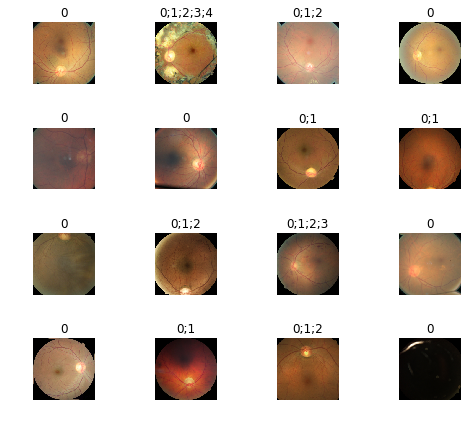

In [15]:
# show some sample images
data.show_batch(rows=4, figsize=(7,6))

In [16]:
def get_preds(arr):
    mask = arr == 0
    return np.clip(np.where(mask.any(1), mask.argmax(1), 5) - 1, 0, 4)

In [17]:
last_output = torch.tensor([
    [1.7226, 1.7226, 1.7226, 1.7226, 1.7226],
    [0, 0, 0, 0, 1.7226],
    [0.12841, -7.6266, -6.3899, -2.1333, -0.48995],
    [0.68119, 1.7226, -1.9895, -0.097746, 0.53576]
])
arr = (torch.sigmoid(last_output) > 0.5).numpy(); arr

array([[ True,  True,  True,  True,  True],
       [False, False, False, False,  True],
       [ True, False, False, False, False],
       [ True,  True, False, False,  True]])

In [18]:
# Test output
assert (get_preds(arr) == np.array([4, 0, 0, 1])).all()

In [19]:
class ConfusionMatrix(Callback):
    "Computes the confusion matrix."

    def on_train_begin(self, **kwargs):
        self.n_classes = 0

    def on_epoch_begin(self, **kwargs):
        self.cm = None

    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        preds = torch.tensor(get_preds((torch.sigmoid(last_output) > 0.5).cpu().numpy()))
        
        targs = torch.tensor(get_preds(last_target.cpu().numpy()))

        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])).sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def on_epoch_end(self, **kwargs):
        self.metric = self.cm
        

@dataclass
class KappaScore(ConfusionMatrix):
    "Compute the rate of agreement (Cohens Kappa)."
    weights:Optional[str]=None      # None, `linear`, or `quadratic`

    def on_epoch_end(self, last_metrics, **kwargs):
        sum0 = self.cm.sum(dim=0)
        sum1 = self.cm.sum(dim=1)
        expected = torch.einsum('i,j->ij', (sum0, sum1)) / sum0.sum()
        if self.weights is None:
            w = torch.ones((self.n_classes, self.n_classes))
            w[self.x, self.x] = 0
        elif self.weights == "linear" or self.weights == "quadratic":
            w = torch.zeros((self.n_classes, self.n_classes))
            w += torch.arange(self.n_classes, dtype=torch.float)
            w = torch.abs(w - torch.t(w)) if self.weights == "linear" else (w - torch.t(w)) ** 2
        else: raise ValueError('Unknown weights. Expected None, "linear", or "quadratic".')
        k = torch.sum(w * self.cm) / torch.sum(w * expected)
        return add_metrics(last_metrics, 1-k)

In [20]:
# from torch.utils.data.sampler import WeightedRandomSampler
# class OverSamplingCallback(LearnerCallback):
#     def __init__(self,learn:Learner):
#         super().__init__(learn)
#         self.labels = self.learn.data.train_dl.dataset.y.items
#         _, counts = np.unique(self.labels,return_counts=True)
#         self.weights = torch.DoubleTensor((1/counts)[self.labels])
#         self.label_counts = np.bincount([self.learn.data.train_dl.dataset.y[i].data \
#                                          for i in range(len(self.learn.data.train_dl.dataset))])
#         self.total_len_oversample = int(self.learn.data.c*np.max(self.label_counts))
        
#     def on_train_begin(self, **kwargs):
#         self.learn.data.train_dl.dl.batch_sampler = \
#         BatchSampler(WeightedRandomSampler(self.weights,self.total_len_oversample), self.learn.data.train_dl.batch_size,False)

In [21]:
kappa = KappaScore(weights="quadratic")

# build model (use resnet34)
learn = create_cnn(data, models.resnet50, metrics=[kappa, accuracy_thresh], 
                   callback_fns = [
                                partial(EarlyStoppingCallback, monitor='kappa_score', min_delta=0.001, patience=1),
                                partial(ReduceLROnPlateauCallback),
#                               partial(GradientClipping, clip=0.2),
                                partial(SaveModelCallback, every = 'improvement', monitor='kappa_score', name='bestordinal')],
                   model_dir="/tmp").to_fp16()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02
Min loss divided by 10: 2.51E-02


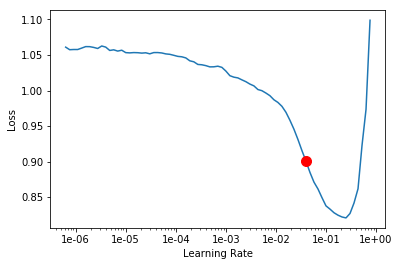

In [23]:
learn.recorder.plot(suggestion=True)

In [24]:
#first time learning
lr = 2e-2
learn.fit_one_cycle(10, lr)
learn.freeze_to(-3)
learn.fit_one_cycle(5,slice(lr/10,lr/4))

epoch,train_loss,valid_loss,kappa_score,accuracy_thresh,time
0,0.232424,0.217577,0.547093,0.918207,25:11
1,0.215212,0.224022,0.410039,0.913680,24:00


Better model found at epoch 0 with kappa_score value: 0.5470927357673645.
Epoch 1: reducing lr to 0.0030399999999999997
Epoch 2: early stopping
Epoch 2: reducing lr to 0.004


epoch,train_loss,valid_loss,kappa_score,accuracy_thresh,time
0,0.237379,0.366980,0.138757,0.873338,26:08
1,0.238880,0.253056,0.274104,0.901865,26:24
2,0.216290,0.233701,0.304489,0.907075,25:05
3,0.199879,0.200954,0.472360,0.919858,24:40
4,0.185499,0.188033,0.572909,0.925922,24:20


Better model found at epoch 0 with kappa_score value: 0.13875681161880493.
Better model found at epoch 1 with kappa_score value: 0.27410370111465454.
Better model found at epoch 2 with kappa_score value: 0.3044893741607666.
Better model found at epoch 3 with kappa_score value: 0.4723604917526245.
Better model found at epoch 4 with kappa_score value: 0.5729093551635742.


In [25]:
df_train2 = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_train2['label'] = df_train2.diagnosis.apply(get_label)

In [26]:
data = ImageDataBunch.from_df('./', 
                              df=df_train2, 
                              valid_pct=0.2,
                              folder="../input/aptos2019-blindness-detection/train_images",
                              suffix=".png",
                              ds_tfms=get_transforms(flip_vert=True,max_warp=0.),
                              size=256,
                              resize_method=ResizeMethod.SQUISH,
                              bs=96, 
                              num_workers=4,
                             label_col='label', label_delim=',').normalize(imagenet_stats)

In [27]:
learn.data = data
learn.to_fp16();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-03


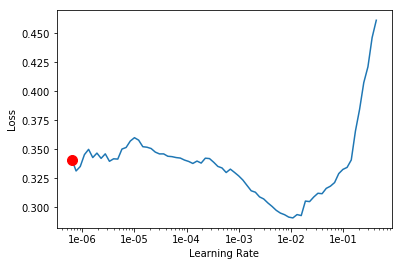

In [28]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [29]:
lr2 = 1e-3
learn.fit_one_cycle(10, lr2)
learn.freeze_to(-3)
learn.fit_one_cycle(10, slice(lr2/10,lr2/4))

epoch,train_loss,valid_loss,kappa_score,accuracy_thresh,time
0,0.298205,0.219949,0.674009,0.910929,07:51
1,0.228000,0.162340,0.827636,0.940164,07:47
2,0.193549,0.142134,0.864641,0.943169,07:46
3,0.169507,0.142120,0.845282,0.943716,07:48
4,0.154289,0.130492,0.874607,0.949454,07:45
5,0.144085,0.134699,0.878079,0.945355,07:46
6,0.134334,0.131059,0.869545,0.949727,07:45
7,0.129999,0.121501,0.888717,0.953005,07:42
8,0.126025,0.123084,0.881952,0.948361,07:48


Better model found at epoch 0 with kappa_score value: 0.6740086078643799.
Better model found at epoch 1 with kappa_score value: 0.8276364803314209.
Better model found at epoch 2 with kappa_score value: 0.8646414279937744.
Better model found at epoch 4 with kappa_score value: 0.8746070861816406.
Epoch 5: reducing lr to 0.00012225240438725783
Better model found at epoch 5 with kappa_score value: 0.8780794739723206.
Epoch 6: reducing lr to 7.774839561274215e-05
Better model found at epoch 7 with kappa_score value: 0.8887171149253845.
Epoch 8: reducing lr to 9.903873597305257e-06
Epoch 9: early stopping
Better model found at epoch 9 with kappa_score value: 0.8889092803001404.


epoch,train_loss,valid_loss,kappa_score,accuracy_thresh,time
0,0.116657,0.121114,0.886536,0.950820,07:46
1,0.118712,0.121540,0.883878,0.950820,07:45


Better model found at epoch 0 with kappa_score value: 0.8865358829498291.
Epoch 1: reducing lr to 3.8e-05
Epoch 2: early stopping
Epoch 2: reducing lr to 5.0000000000000016e-05


In [30]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(lr2/100,lr2/20))
learn.freeze()
learn.fit_one_cycle(5,2e-3)

epoch,train_loss,valid_loss,kappa_score,accuracy_thresh,time
0,0.120727,0.121058,0.884122,0.951366,07:43
1,0.120171,0.120631,0.888650,0.953005,07:44
2,0.119838,0.120535,0.884799,0.951913,07:42


Better model found at epoch 0 with kappa_score value: 0.8841220736503601.
Better model found at epoch 1 with kappa_score value: 0.8886502981185913.
Epoch 3: early stopping


epoch,train_loss,valid_loss,kappa_score,accuracy_thresh,time
0,0.122218,0.121207,0.892116,0.954372,07:40
1,0.122128,0.125171,0.890475,0.950820,07:43


Better model found at epoch 0 with kappa_score value: 0.8921164274215698.
Epoch 1: reducing lr to 0.0003801938528053895
Epoch 2: early stopping


In [31]:
# #Adding Weight decay for regulization
# learn.fit_one_cycle(5,wd=1e-1)
# learn.save('stage-1')

In [32]:
# learn.unfreeze()
# learn.lr_find()
# learn.recorder.plot()

In [33]:
# learn.load('bestordinal')
# learn.unfreeze()
# learn.fit_one_cycle(15, max_lr=slice(1e-9,3e-5 ),wd=1e-1)

In [34]:
learn.load('bestordinal')
sample_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [35]:
learn.data.add_test(ImageList.from_df(sample_df,'../input/aptos2019-blindness-detection',folder='test_images',suffix='.png'))

In [36]:
preds, y = learn.get_preds(DatasetType.Test)

In [37]:
preds

tensor([[1.0000, 0.8282, 0.4842, 0.1945, 0.1709],
        [1.0000, 0.9983, 0.9878, 0.7644, 0.3343],
        [1.0000, 0.9928, 0.8706, 0.2203, 0.1353],
        ...,
        [1.0000, 0.9932, 0.9358, 0.4868, 0.2864],
        [1.0000, 0.9988, 0.9958, 0.9030, 0.5088],
        [1.0000, 0.0742, 0.0464, 0.0270, 0.0257]])

In [38]:
sample_df.diagnosis = get_preds((preds > 0.5).cpu().numpy())
sample_df.diagnosis.value_counts()

2    904
0    356
1    287
3    276
4    105
Name: diagnosis, dtype: int64

In [39]:
sample_df.head(10)

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,3
7,0111b949947e,0
8,01499815e469,4
9,0167076e7089,0


In [40]:
sample_df.to_csv('submission.csv',index=False)

In [41]:
!mv {learn.model_dir}/*.pth .
os.listdir()

['__notebook__.ipynb',
 '__output__.json',
 'bestordinal.pth',
 'submission.csv',
 'tmp.pth']